In [3]:
import cv2
import sys
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
from projeto_helper import BeerClassification
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

PATH = 'C:\\Users\\marco\\Google Drive\\ComputerScience\\Visão Computacional\\images\\Skol'

In [13]:
ids = ['0', '1', '2', '3']
bc = BeerClassification(PATH, ids)
# for i, label in enumerate(bc.labels):
#     print(i, label)
len(bc.imgs)

600

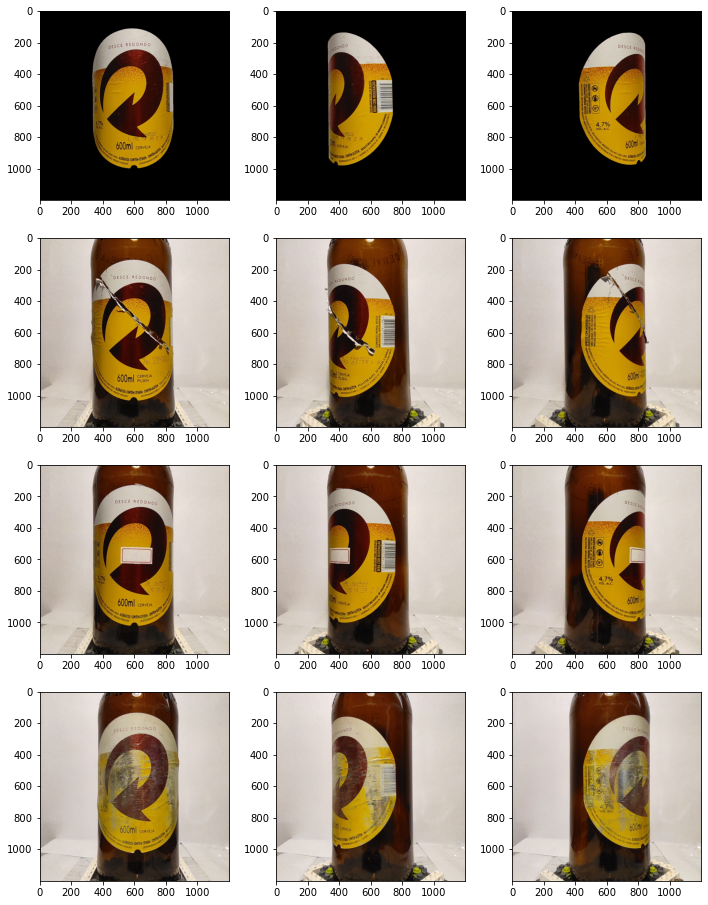

In [5]:
query_imgs = []
for i in range(3):
    query_imgs.append(plt.imread(bc.imgs[i]))
query_idxs = [0, 1, 2]
masks = [
    plt.imread(join(PATH, 'mask0.jpg')),
    plt.imread(join(PATH, 'mask45L.jpg')),
    plt.imread(join(PATH, 'mask45R.jpg'))
]
for i in range(3):
    query_imgs[i] = cv2.bitwise_and(query_imgs[i], masks[i])

train_imgs = [
    plt.imread(bc.imgs[240]), plt.imread(bc.imgs[241]), plt.imread(bc.imgs[242]),
    plt.imread(bc.imgs[360]), plt.imread(bc.imgs[361]), plt.imread(bc.imgs[362]),
    plt.imread(bc.imgs[480]), plt.imread(bc.imgs[481]), plt.imread(bc.imgs[482])
]

fig, axs = plt.subplots(4, 3, figsize=(12, 16))
for i in range(3):
    axs[0, i].imshow(query_imgs[i])
for i in range(1, 4):
    for j in range(3):
        axs[i, j].imshow(train_imgs[(i - 1) * 3 + j])
plt.show()

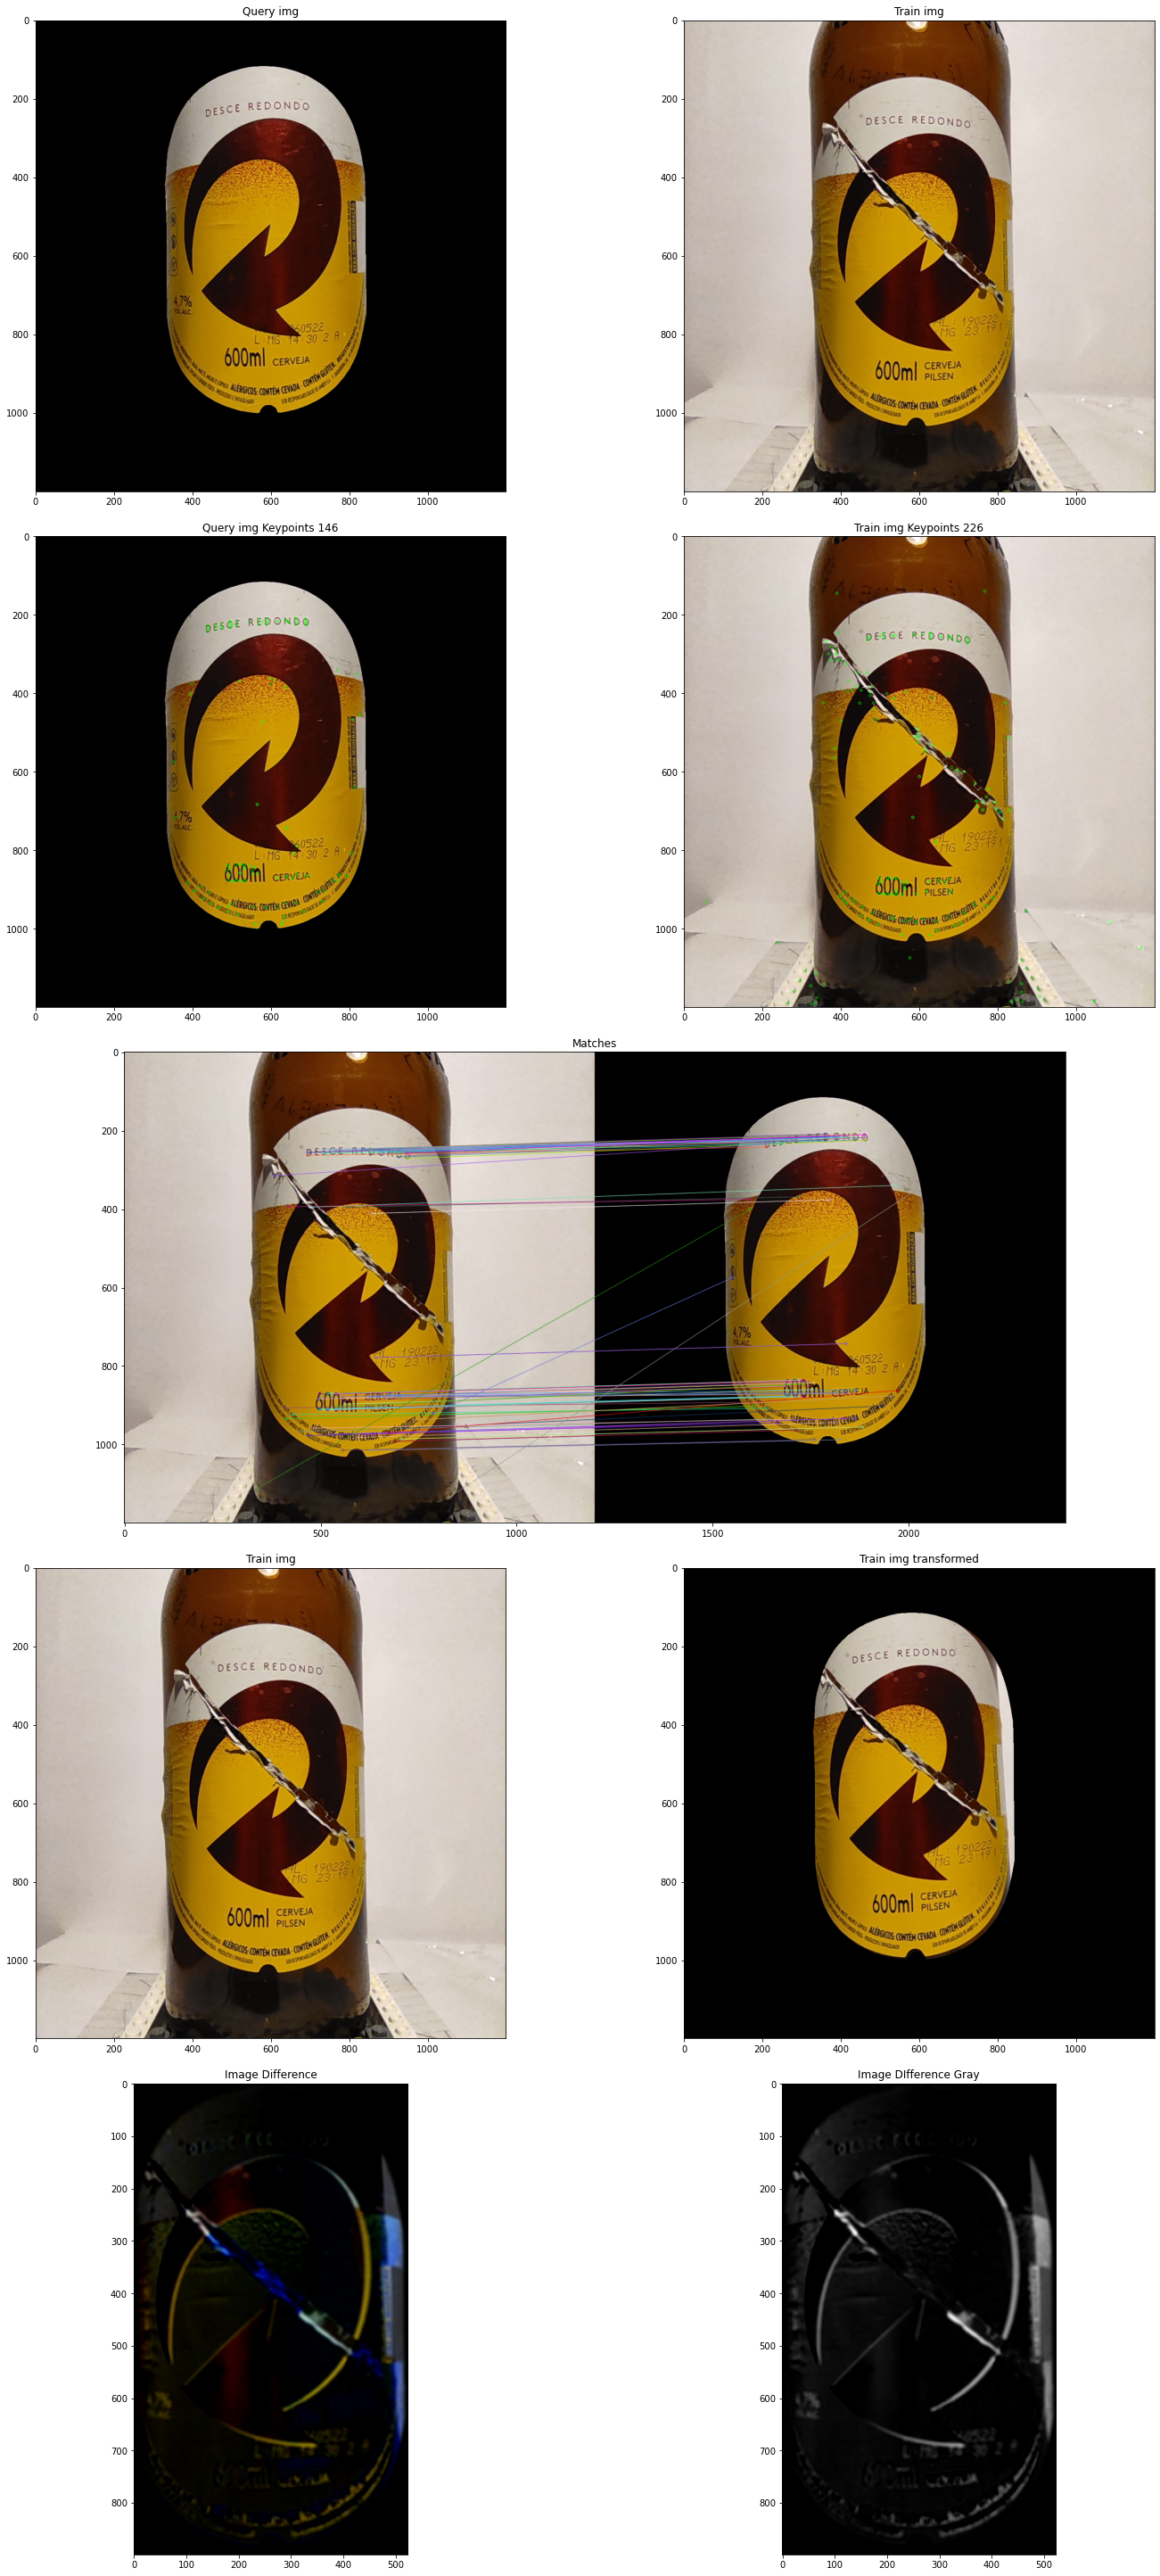

In [6]:
img_diff = bc.processGetDiff(query_imgs[0], masks[0], train_imgs[0], plot=True)

In [7]:
# bc.processGetDiffAllImages(query_imgs, query_idxs, masks, 'temp')

In [12]:
model = OneClassSVM(nu=0.15)
history = []
for i in ids:
    print(f'Testing images: [\'0\', \'{i}\']')
    history.append(bc.thresholdAllImages(model, 'train', 'test', test_ids=['0', i], T=25))
print(f'Id: {ids}')
history.append(bc.thresholdAllImages(model, 'train', 'test', test_ids=ids, T=25))

Testing images: ['0', '0']
Train ->    Error: 11/117 | 0.094    Acuracy: 0.906
Test ->     Error: 19/120 | 0.158    Acuracy: 0.842
Testing images: ['0', '1']
Train ->    Error: 11/117 | 0.094    Acuracy: 0.906
Test ->     Error: 20/240 | 0.083    Acuracy: 0.917
Testing images: ['0', '2']
Train ->    Error: 11/117 | 0.094    Acuracy: 0.906
Test ->     Error: 21/240 | 0.087    Acuracy: 0.912
Testing images: ['0', '3']
Train ->    Error: 11/117 | 0.094    Acuracy: 0.906
Test ->     Error: 26/240 | 0.108    Acuracy: 0.892
Id: ['0', '1', '2', '3']
Train ->    Error: 11/117 | 0.094    Acuracy: 0.906
Test ->     Error: 29/480 | 0.060    Acuracy: 0.940


In [9]:
model = IsolationForest(contamination=0.15, random_state=42)
history = []
for i in ids:
    print(f'Testing images: [\'0\', \'{i}\']')
    history.append(bc.thresholdAllImages(model, 'train', 'test', test_ids=['0', i], T=25))
print(f'Id: {ids}')
history.append(bc.thresholdAllImages(model, 'train', 'test', test_ids=ids, T=25))

Testing images: ['0', '0']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 26/120 | 0.217    Acuracy: 0.783
Testing images: ['0', '1']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 26/240 | 0.108    Acuracy: 0.892
Testing images: ['0', '2']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 26/240 | 0.108    Acuracy: 0.892
Testing images: ['0', '3']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 29/240 | 0.121    Acuracy: 0.879
Id: ['0', '1', '2', '3']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 29/480 | 0.060    Acuracy: 0.940


In [10]:
model = OneClassSVM(nu=0.5)
history = []
for i in ids:
    print(f'Testing images: [\'0\', \'{i}\']')
    history.append(bc.compareHistogramAllImages(model, 'train', 'test', test_ids=['0', i]))
print(f'Id: {ids}')
history.append(bc.compareHistogramAllImages(model, 'train', 'test', test_ids=ids))

Testing images: ['0', '0']
Train ->    Error: 50/117 | 0.427    Acuracy: 0.573
Test ->     Error: 61/120 | 0.508    Acuracy: 0.492
Testing images: ['0', '1']
Train ->    Error: 50/117 | 0.427    Acuracy: 0.573
Test ->     Error: 61/240 | 0.254    Acuracy: 0.746
Testing images: ['0', '2']
Train ->    Error: 50/117 | 0.427    Acuracy: 0.573
Test ->     Error: 62/240 | 0.258    Acuracy: 0.742
Testing images: ['0', '3']
Train ->    Error: 50/117 | 0.427    Acuracy: 0.573
Test ->     Error: 61/240 | 0.254    Acuracy: 0.746
Id: ['0', '1', '2', '3']
Train ->    Error: 50/117 | 0.427    Acuracy: 0.573
Test ->     Error: 62/480 | 0.129    Acuracy: 0.871


In [11]:
model = IsolationForest(contamination=0.15, random_state=42)
history = []
for i in ids:
    print(f'Testing images: [\'0\', \'{i}\']')
    history.append(bc.compareHistogramAllImages(model, 'train', 'test', test_ids=['0', i]))
print(f'Id: {ids}')
history.append(bc.compareHistogramAllImages(model, 'train', 'test', test_ids=ids))

Testing images: ['0', '0']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 21/120 | 0.175    Acuracy: 0.825
Testing images: ['0', '1']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 21/240 | 0.087    Acuracy: 0.912
Testing images: ['0', '2']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 21/240 | 0.087    Acuracy: 0.912
Testing images: ['0', '3']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 22/240 | 0.092    Acuracy: 0.908
Id: ['0', '1', '2', '3']
Train ->    Error: 18/117 | 0.154    Acuracy: 0.846
Test ->     Error: 22/480 | 0.046    Acuracy: 0.954
